In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error, mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from hyperopt import hp, fmin, STATUS_OK, tpe, Trials

In [ ]:
def set_settings():
    tf.enable_v2_behavior()
    sns.reset_defaults()
    sns.set_context(context='talk',font_scale=0.7)
    tfd = tfp.distributions

In [ ]:
def mount():
    drive.mount('/content/drive')

In [ ]:
def check_gpu_device():
    if tf.test.gpu_device_name() != '/device:GPU:0':
        print('WARNING: GPU device not found.')
    else:
        print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

In [ ]:
def prepare():
    set_settings()
    mount()
    check_gpu_device()

In [ ]:
def load():
    data = pd.read_csv('drive/MyDrive/rcsed_z_less_03.csv')
    masses = pd.read_csv('drive/MyDrive/rcsed_z_less_03_logMstar_gal.csv')
    return data, masses

In [ ]:
def prepare_data(data, masses):
    mask = ~masses['logMstar_gal'].isna()
    y = masses[mask]
    y = y.reset_index()
    y = y.drop(columns=['index'])
    data = data.drop(columns=['Unnamed: 0'])
    X = data[mask]
    X = X.reset_index()
    X = X.drop(columns=['index'])
    X = X.fillna(X.mean())
    data['g_r'] = (data['g'] + data['kcorr_g']) - (data['r'] + data['kcorr_r'])
    X['g_r'] = (X['g'] + X['kcorr_g']) - (X['r'] + X['kcorr_r'])
    return data, X, y, mask

In [ ]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
def scale_data(X_train, X_test):
    scal = preprocessing.RobustScaler()
    X_train = scal.fit_transform(X_train)
    X_test = scal.transform(X_test)
    return X_train, X_test

In [ ]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])


def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [ ]:
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')

    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

In [ ]:
def var_model(X_train, y_train):
    tf.keras.backend.set_floatx('float64')
# Build model.
    num_inducing_points = 100
    simple_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[56]),
        tf.keras.layers.Dense(256, kernel_initializer='ones', use_bias=False, activation='relu'),
        #tf.keras.layers.Activation('softmax'),

        tfp.layers.VariationalGaussianProcess(
            num_inducing_points=num_inducing_points,
            kernel_provider=RBFKernelFn(),
            event_shape=[1],
            unconstrained_observation_noise_variance_initializer=(
                tf.constant_initializer(np.log(np.expm1(1.)).astype('float64'))),
        ),
    ])
    batch_size = 256
    loss = lambda y, rv_y: rv_y.variational_loss(
        y, kl_weight=np.array(batch_size, 'float64') / X.shape[0])
    simple_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.008), loss=loss)

    history = simple_model.fit(X_train, y_train, batch_size=batch_size, epochs=77, verbose=2)
    return simple_model, history

In [ ]:
class EnumHyper:

    def __init__(self, estimator_func, X_train, X_test, y_train, y_test, size, random_st, params_strs, types, low, high):
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X_train, y_train, test_size=size, random_state=random_st)
        self.X_test = X_test
        self.y_test = y_test
        self.estimator_func = estimator_func
        self.params_strs = params_strs.copy()
        self.low = low.copy()
        self.high = high.copy()
        self.m = self.params_strs.shape[0]
        self.types = types


    def fn(self, params):
        for key in params:
            params[key] = self.types(params[key])
        est = self.estimator_func(**params)
        y_pred = est.fit(self.X_train, self.y_train).predict(self.X_valid)
        loss = 1 - r2_score(self.y_valid, y_pred)
        return {'loss' : loss, 'status' : STATUS_OK}


    def find_pars(self):
        space = {}
        for i in range(self.m):
            space[self.params_strs[i]] = hp.uniform(label = self.params_strs[i], low = self.low[i], high = self.high[i])
        best_params = fmin(fn=self.fn, space=space, algo=tpe.suggest, max_evals=50, verbose=False)
        return best_params


    def evaluate(self, best_params):
        for key in best_params:
            best_params[key] = self.types(best_params[key])
        est = self.estimator_func(**best_params)
        est.fit(self.X_train, self.y_train)
        y_pred_train = est.predict(self.X_train)
        y_pred_test = est.predict(self.X_test)
        sc_train = r2_score(self.y_test, y_pred_train)
        sc_test = r2_score(self.y_test, y_pred_test)
        return est, sc_train, sc_test

    def enum(self):
        best_params = self.find_pars()
        est, sc_train, sc_test = self.evaluate(best_params)
        return est, sc_train, sc_test

In [ ]:
def randForest_model(X_train, y_train):
    estimators = [150, 200]
    min_spl = [4, 5, 6]
    best_sc_first = 0
    best_est = 0
    for est in tqdm_notebook(estimators):
        rgr = RandomForestRegressor(n_estimators=est)
        rgr.fit(X_train, y_train)
        y_pred = rgr.predict(X_test)
        sc = r2_score(y_pred, y_test)
        if sc > best_sc_first:
            best_sc_first = sc
            best_est = est


    result_est = None
    best_sc_second = 0
    best_pred = None
    best_min = 0
    for cur_min in tqdm_notebook(min_spl):
        rgr = RandomForestRegressor(n_estimators=best_est, min_samples_split=cur_min)
        rgr.fit(X_train, y_train)
        y_pred = rgr.predict(X_test)
        sc = r2_score(y_pred, y_test)
        if sc > best_sc_second:
            best_sc_second = sc
            best_min = cur_min
            result_est = rgr
            best_pred = y_pred

    return result_est

In [ ]:
def randForest_model2(X_train, y_train):
    rgr = RandomForestRegressor()
    rgr.fit(X_train, y_train)
    return rgr

In [ ]:
def randForest_model3(X_train, y_train, X_test, y_test):
    enhp = EnumHyper(RandomForestRegressor, X_train, X_test, y_train, y_test, 0.33, 42, np.array(['n_estimators', 'min_samples_split']), int, [50, 4], [200, 10])
    est, sc_train, sc_test = enhp.enum()
    return est, sc_train, sc_test

In [ ]:
def lin_reg(X_train, y_train):
    rgr = LinearRegression()
    rgr.fit(X_train, y_train)
    return rgr

In [ ]:
def boosting_model(X_train, X_test, y_train, y_test):
    estimators = [50, 100, 150, 200]
    lr = [0.001, 0.01, 0.1, 0.2, 0.3]
    best_sc_first = 0
    best_est = 0
    for est in tqdm_notebook(estimators):
        rgr = XGBRegressor(n_estimators=est)
        rgr.fit(X_train, y_train)
        y_pred = rgr.predict(X_test)
        sc = r2_score(y_pred, y_test)
        if sc > best_sc_first:
            best_sc_first = sc
            best_est = est


    result_est = None
    best_sc_second = 0
    best_pred = None
    best_lr = 0
    for cur_lr in tqdm_notebook(lr):
        rgr = XGBRegressor(n_estimators=best_est, learning_rate=cur_lr)
        rgr.fit(X_train, y_train)
        y_pred = rgr.predict(X_test)
        sc = r2_score(y_pred, y_test)
        if sc > best_sc_second:
            best_sc_second = sc
            best_lr = cur_lr
            result_est = rgr
            best_pred = y_pred
    return result_est

In [ ]:
def make_predictions(model, X_train, X_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    return y_pred_train, y_pred_test

In [ ]:
def print_score(y, y_pred):
    print('max_error:',max_error(y, y_pred))
    print('mean_squared_error:',mean_squared_error(y, y_pred))
    print('explained_variance_score:', explained_variance_score(y, y_pred))
    print('mean_absolute_error:', mean_absolute_error(y, y_pred))
    print('mean_squared_log_error:', mean_squared_log_error(y, y_pred))
    print('median_absolute_error:', median_absolute_error(y, y_pred))
    print('r2_score:', r2_score(y, y_pred))
    print('mean_poisson_deviance:', mean_poisson_deviance(y, y_pred))
    print('mean_gamma_deviance:', mean_gamma_deviance(y, y_pred))
    return r2_score(y, y_pred)

In [ ]:
def scores(model, X_train, X_test, y_train, y_test):
    y_pred_train, y_pred_test = make_predictions(model, X_train, X_test)
    r2_train = print_score(y_train, y_pred_train)
    r2_test = print_score(y_test, y_pred_test)
    return r2_train, r2_test

In [ ]:
def feature_importance(model):
    importance = model.feature_importances_
    importance2 = list(filter(lambda x: x > 0.0045, importance))
    # summarize feature importance
    massiv = X.columns
    massiv2 = []
    i = 0
    for v in range(len(importance)):
      if v == 52:
        break
      if importance[v] == importance2[i]:
        print('Column: %s, Feature: %0d,  Score: %.5f' % (massiv[v], v, importance2[i]))
        massiv2.append(massiv[v])
        i += 1

    # plot feature importance
    pyplot.bar(massiv2, importance2)
    pyplot.xticks(rotation=90)
    pyplot.show()
    return massiv2

In [ ]:
def get_masses_for_unlabeled(model, data, mask):
    other_mask = 1 -  mask
    other_mask = other_mask.astype('bool')
    X_other = data[other_mask]
    X_other = X_other.reset_index()
    X_other = X_other.drop(columns=['index'])
    X_other = X_other.fillna(X_other.mean())
    res = model.predict(X_other)
    inds = np.arange(len(data))
    inds = inds[other_mask]
    my_masses = {'inds': inds, 'masses' : res}
    #df = pd.DataFrame(my_masses)
    return res

In [ ]:
def draw(model):
    yhat = model.predict(X_test)
    plt.figure(figsize=[15, 10])  # inches
    plt.plot(X, y, 'b.', label='observed', markersize=2);

    m = yhat.mean()
    s = np.std(yhat)

    plt.plot(X_test, yhat, 'r', linewidth=0.1, label='mean');
    plt.plot(X_test, yhat + 2 * s, 'g', linewidth=0.1, label=r'mean + 2 stddev');
    plt.plot(X_test, yhat - 2 * s, 'g', linewidth=0.1, label=r'mean - 2 stddev');



    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_smart_bounds(True)
    #ax.spines['bottom'].set_smart_bounds(True)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5), fontsize=5)
    plt.show()

In [ ]:
def make_all_hist(model, y_train, y_test, data, mask):
    others_y = get_masses_for_unlabeled(model, data, mask)
    sns.distplot(y_train, label='y_train')
    sns.distplot(y_test, label='y_test')
    sns.distplot(others_y, label='predicted_masses')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
def save_csv(df):
    compression_opts = dict(method='zip',
                        archive_name='out.csv')

    df.to_csv('out.zip', index=False,
          compression=compression_opts)

In [ ]:
prepare()

Mounted at /content/drive
SUCCESS: Found GPU: /device:GPU:0


In [ ]:
data, masses = load()

FileNotFoundError: ignored

In [ ]:
data

,Unnamed: 0,r2id_obj,ra_obj,dec_obj,redshift,amaj,ell,pa,fuv,fuv_err,fuv_size,kcorr_fuv,nuv,nuv_err,nuv_size,kcorr_nuv,u,u_err,u_size,kcorr_u,g,g_err,g_size,kcorr_g,r,r_err,r_size,kcorr_r,i,i_err,i_size,kcorr_i,z,z_err,z_size,kcorr_z,y,y_err,kcorr_y,j,j_err,kcorr_j,h,h_err,kcorr_h,k,k_err,kcorr_k,w1,w1_err,w2,w2_err,w3,w3_err,w4,w4_err
0,11,4964732,119.429449,52.995309,0.169052,5.174065,0.147545,75.428020,NaN,NaN,NaN,NaN,23.411406,0.803679,5.977952,0.545470,19.658782,0.186940,4.173847,0.294785,18.553901,0.030362,2.375188,0.515064,17.386399,0.020019,2.205640,0.168766,16.935629,0.025175,2.001972,0.083567,16.613500,0.051524,1.973587,0.039130,NaN,NaN,NaN,16.235859,0.030124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.262477,0.047,17.720986,0.048,17.344103,NaN,15.125856,NaN
1,19,4984675,171.950334,34.842062,0.042331,7.208284,0.742261,167.488800,20.772176,0.291849,3.5000,-0.023631,20.410298,0.118091,3.500000,0.009749,18.764511,0.122624,4.832413,0.121685,17.986342,0.020978,3.349131,0.053598,17.433048,0.020732,3.363956,0.036475,17.175305,0.025925,3.130031,0.000419,16.878486,0.074337,3.337605,0.011275,NaN,NaN,NaN,16.811426,0.069116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.180280,0.031,18.739711,0.047,16.582489,0.178,15.513918,NaN
2,21,4929008,229.317800,10.181280,0.059361,2.528525,0.547619,88.666280,NaN,NaN,NaN,NaN,21.859837,0.369446,3.500000,0.190795,18.780715,0.046751,1.218059,0.180941,17.115493,0.013880,1.169020,0.101875,16.451456,0.013966,1.163245,0.047751,16.146245,0.014310,1.153531,0.011143,15.904148,0.016994,1.180392,0.007042,15.451216,0.007531,0.018961,15.260725,0.007872,-0.025315,15.072135,0.011905,0.003010,15.228353,0.011539,-0.126780,16.290263,0.014,16.903854,0.012,17.320075,NaN,15.222852,NaN
3,36,5085135,2.593309,18.374851,0.171086,7.360223,0.357204,18.848080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.980644,1.283242,4.630747,-0.024583,22.601471,1.094536,1.439304,-0.029259,20.621648,0.139686,1.947570,-0.120074,19.969107,0.168316,1.497659,-0.223952,19.933580,0.531365,1.227112,0.019985,NaN,NaN,NaN,19.399256,0.210281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.738589,0.037,19.273824,0.071,16.601845,NaN,14.857815,NaN
4,40,4953301,223.510943,30.590311,0.105039,3.675426,0.594037,79.198190,21.593038,0.334868,3.5000,-0.004249,21.018972,0.209499,3.500000,0.009463,19.679360,0.097814,1.821242,0.161748,18.287194,0.012582,1.791371,0.139702,17.605897,0.010579,1.730272,0.046276,17.199028,0.011134,1.591608,-0.000667,16.847751,0.032656,1.641510,0.021436,NaN,NaN,NaN,16.523225,0.040377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.947873,0.071,16.945460,0.065,14.929433,0.029,13.848909,0.090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652055,4712456,882789,41.771824,-26.326319,0.039340,4.282000,0.185675,49.725961,22.127898,0.225285,3.8083,0.182576,21.022361,0.098852,3.500000,NaN,NaN,NaN,NaN,NaN,20.012959,0.104666,NaN,0.608065,18.899818,0.038716,NaN,0.143761,18.201648,0.006626,3.960000,0.021834,18.305663,0.022567,NaN,0.015086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.953354,0.021,18.249756,0.027,NaN,NaN,NaN,NaN
1652056,4712457,3809143,2.118993,17.437530,0.067905,7.530045,0.267341,-0.020800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.384469,0.083983,5.173516,0.201118,16.820296,0.011034,3.166468,0.163659,15.940846,0.008213,3.125782,0.063800,15.565904,0.007487,2.890614,0.041873,15.273295,0.019930,2.757155,0.016281,NaN,NaN,NaN,15.035498,0.012558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.058192,0.469,14.695871,NaN
1652057,4712458,862747,10.077710,-29.285906,0.264760,4.611480,0.013327,55.280522,21.737172,0.455351,3.5000,0.118857,20.832204,0.188371,3.500000,NaN,NaN,NaN,NaN,NaN,18.657043,0.031068,NaN,0.870919,17.341057,0.009339,NaN,0.261753,16.846022,0.003620,4.620000,0.090772,16.548414,0.004510,NaN,0.097325,16.418114,0.010377,0.107160,16.157946,0.007116,-0.057447,15.909260,0.009649,-0.044925,15.693851,0.009513,-0.488879,17.

In [ ]:
data, X, y, mask = prepare_data(data, masses)

In [ ]:
X_train, X_test, y_train, y_test = split_data(X, y)

In [ ]:
X_train, X_test = scale_data(X_train, X_test)

In [ ]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

**Model 1(tf probability)**

In [ ]:
var_model, history = var_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/distributions/gaussian_process.py:312: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


Epoch 1/77


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/distributions/gaussian_process.py:312: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


1301/1301 - 31s - loss: 3482.0813
Epoch 2/77
1301/1301 - 21s - loss: 1019.3092
Epoch 3/77
1301/1301 - 21s - loss: 618.5418
Epoch 4/77
1301/1301 - 21s - loss: 549.5266
Epoch 5/77
1301/1301 - 21s - loss: 436.6702
Epoch 6/77
1301/1301 - 21s - loss: 250.9817
Epoch 7/77
1301/1301 - 21s - loss: 169.3787
Epoch 8/77
1301/1301 - 21s - loss: 154.2299
Epoch 9/77
1301/1301 - 20s - loss: 94.9417
Epoch 10/77
1301/1301 - 21s - loss: 83.1622
Epoch 11/77
1301/1301 - 21s - loss: 80.2810
Epoch 12/77
1301/1301 - 20s - loss: 78.2636
Epoch 13/77
1301/1301 - 20s - loss: 75.9960
Epoch 14/77
1301/1301 - 21s - loss: 74.5342
Epoch 15/77
1301/1301 - 20s - loss: 73.3239
Epoch 16/77
1301/1301 - 20s - loss: 73.3127
Epoch 17/77
1301/1301 - 20s - loss: 70.5611
Epoch 18/77
1301/1301 - 21s - loss: 70.4149
Epoch 19/77
1301/1301 - 21s - loss: 70.0924
Epoch 20/77
1301/1301 - 20s - loss: 69.2654
Epoch 21/77
1301/1301 - 20s - loss: 67.9017
Epoch 22/77
1301/1301 - 20s - loss: 67.6659
Epoch 23/77
1301/1301 - 20s - loss: 67.136

In [ ]:
simple_model_train_r2, simple_model_test_r2 = scores(var_model, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/distributions/gaussian_process.py:312: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


max_error: 3.6319600527127394
mean_squared_error: 0.06537914751874994
explained_variance_score: 0.8394809572931362
mean_absolute_error: 0.1970020794829775
mean_squared_log_error: 0.0005360403621996605
median_absolute_error: 0.1614433488200886
r2_score: 0.8389695957298822
mean_poisson_deviance: 0.006487060059275517
mean_gamma_deviance: 0.0006470657849331218
max_error: 2.546977178063833
mean_squared_error: 0.06774334894390754
explained_variance_score: 0.8325182550517467
mean_absolute_error: 0.20047667284846576
mean_squared_log_error: 0.0005540694772273253
median_absolute_error: 0.16354486843379235
r2_score: 0.8321923495094898
mean_poisson_deviance: 0.006719226344527823
mean_gamma_deviance: 0.0006699033294093466


**Model 2(RandForest)**

In [ ]:
random_forest_model = randForest_model2(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
random_forest_model_train_r2, random_forest_model_test_r2 = scores(random_forest_model, X_train, X_test, y_train, y_test)

max_error: 1.380146700000009
mean_squared_error: 0.00424098193780529
explained_variance_score: 0.9895552482384918
mean_absolute_error: 0.04665022773412652
mean_squared_log_error: 3.58456878399974e-05
median_absolute_error: 0.03513651666666373
r2_score: 0.989554360038861
mean_poisson_deviance: 0.0004276212970676781
mean_gamma_deviance: 4.351288594156285e-05
max_error: 2.419777866666667
mean_squared_error: 0.030366890384527844
explained_variance_score: 0.9247808252090636
mean_absolute_error: 0.12629480671997548
mean_squared_log_error: 0.00025395405079551187
median_absolute_error: 0.09602551666667036
r2_score: 0.9247779065019376
mean_poisson_deviance: 0.003048255625087361
mean_gamma_deviance: 0.00030768564482355293


**Model 3(Xgboost)**

In [ ]:
boost_model = boosting_model(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[17:22:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[17:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:34:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:45:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



In [ ]:
boost_model_train_r2, boost_model_test_r2 = scores(boost_model, X_train, X_test, y_train, y_test)

max_error: 3.2509816366577153
mean_squared_error: 0.031568822108478944
explained_variance_score: 0.9222452359910515
mean_absolute_error: 0.13023874422392492
mean_squared_log_error: 0.0002639190866206383
median_absolute_error: 0.10096937744140533
r2_score: 0.9222452359905442
mean_poisson_deviance: 0.0031671877891030495
mean_gamma_deviance: 0.00031962692539062035
max_error: 2.5339933605957032
mean_squared_error: 0.03244816053847076
explained_variance_score: 0.9196234826771466
mean_absolute_error: 0.13223357350292977
mean_squared_log_error: 0.00027079035748051917
median_absolute_error: 0.10289205841064497
r2_score: 0.9196223737446426
mean_poisson_deviance: 0.003253586590335407
mean_gamma_deviance: 0.00032804297180663176


**Model 4(LinearRegression)**

In [ ]:
lin_reg_model = lin_reg(X_train, y_train)

In [ ]:
lin_reg_model_train_r2, lin_reg_model_test_r2 = scores(lin_reg_model, X_train, X_test, y_train, y_test)

max_error: 4.711166567119542
mean_squared_error: 0.04619995009772051
explained_variance_score: 0.8862084177625348
mean_absolute_error: 0.1547883243044011
mean_squared_log_error: 0.0003926564974115474
median_absolute_error: 0.11964507696189752
r2_score: 0.8862084177625348
mean_poisson_deviance: 0.004673866679396236
mean_gamma_deviance: 0.00047674188178938406
max_error: 4.397860083114757
mean_squared_error: 0.04826871881438889
explained_variance_score: 0.8804345555932236
mean_absolute_error: 0.15644452586727892
mean_squared_log_error: 0.00040958764004697337
median_absolute_error: 0.12075146880117504
r2_score: 0.8804331285254811
mean_poisson_deviance: 0.004881980834750494
mean_gamma_deviance: 0.0004993926154877516


**Correlation**

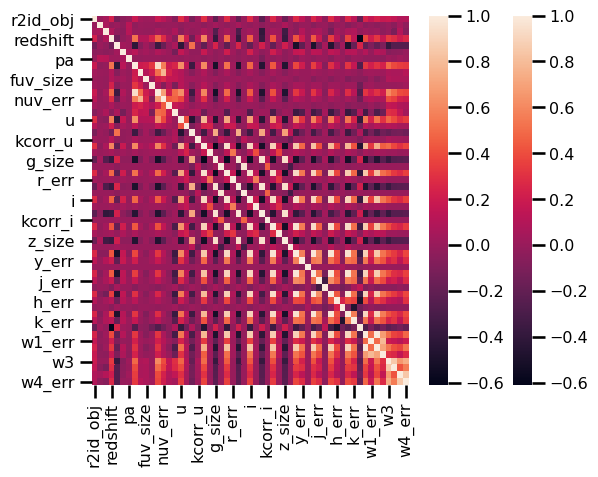

In [ ]:
sns.heatmap(data.corr())
plt.show()

**Feature importance**

Column: redshift, Feature: 3,  Score: 0.15536
Column: kcorr_u, Feature: 18,  Score: 0.01836
Column: kcorr_g, Feature: 22,  Score: 0.45550
Column: r, Feature: 23,  Score: 0.01496
Column: kcorr_r, Feature: 26,  Score: 0.01715
Column: i, Feature: 27,  Score: 0.02958
Column: kcorr_i, Feature: 30,  Score: 0.00507
Column: z, Feature: 31,  Score: 0.16199
Column: w1, Feature: 47,  Score: 0.00505
Column: w2, Feature: 49,  Score: 0.05424
Column: w3, Feature: 51,  Score: 0.01852


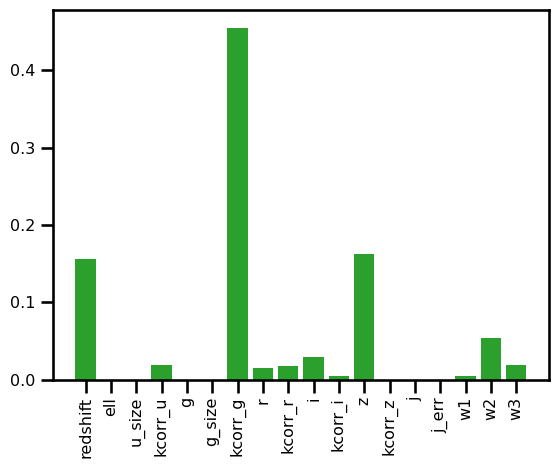

In [ ]:
most_important_features = feature_importance(random_forest_model)

**Сomparison of three models**

In [ ]:
#table
res_table = {'names' : ['variational layer model', 'random forest model', 'boosting model'], 'train' : [simple_model_train_r2, random_forest_model_train_r2, boost_model_train_r2], 'test' : [simple_model_test_r2, random_forest_model_test_r2, boost_model_test_r2]}
res_table = pd.DataFrame(res_table)
res_table

,names,train,test
0,variational layer model,0.838970,0.832192
1,random forest model,0.989554,0.924778
2,boosting model,0.922245,0.919622


**Masses hist**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

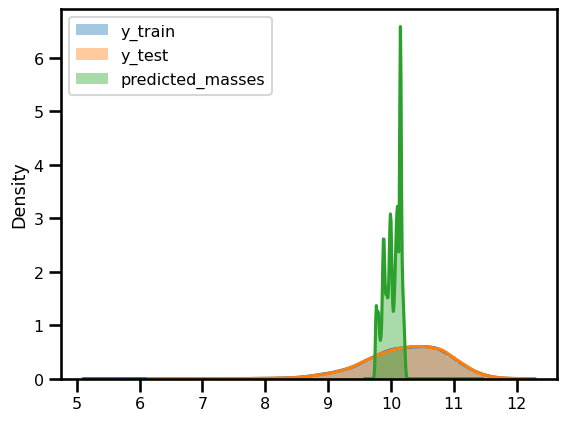

In [ ]:
make_all_hist(random_forest_model, y_train, y_test, data, mask)

In [ ]:
other_mask = 1 -  mask
other_mask = other_mask.astype('bool')
X_other = data[other_mask]
X_other = X_other.reset_index()
X_other = X_other.drop(columns=['index'])
X_other = X_other.fillna(X_other.mean())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

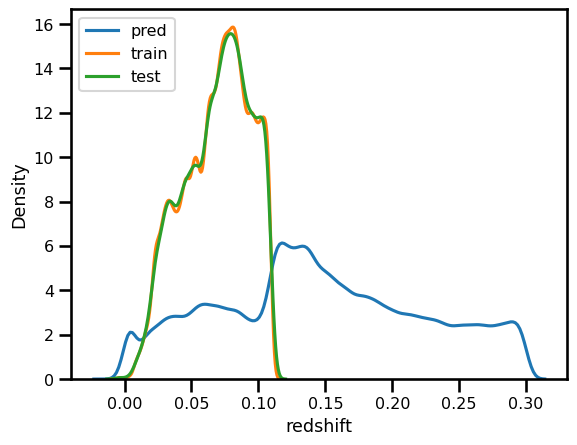

In [ ]:
sns.distplot(X_other['redshift'], label='pred', hist=False)
sns.distplot(X_train['redshift'], label='train',hist=False)
sns.distplot(X_test['redshift'], label='test', hist=False)
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(x, y, '-ok');

**Add new features made of important features + new regression**

In [ ]:
#most_important_features - names of important features
new_data = pd.DataFrame()
for i in data.columns:
  if i in most_important_features:
    new_data[i] = data[i]
new_data

,redshift,kcorr_u,kcorr_g,r,kcorr_r,i,kcorr_i,z,w1,w2,w3
0,0.169052,0.294785,0.515064,17.386399,0.168766,16.935629,0.083567,16.613500,17.262477,17.720986,17.344103
1,0.042331,0.121685,0.053598,17.433048,0.036475,17.175305,0.000419,16.878486,18.180280,18.739711,16.582489
2,0.059361,0.180941,0.101875,16.451456,0.047751,16.146245,0.011143,15.904148,16.290263,16.903854,17.320075
3,0.171086,-0.024583,-0.029259,20.621648,-0.120074,19.969107,-0.223952,19.933580,18.738589,19.273824,16.601845
4,0.105039,0.161748,0.139702,17.605897,0.046276,17.199028,-0.000667,16.847751,16.947873,16.945460,14.929433
...,...,...,...,...,...,...,...,...,...,...,...
1652055,0.039340,NaN,0.608065,18.899818,0.143761,18.201648,0.021834,18.305663,17.953354,18.249756,NaN
1652056,0.067905,0.201118,0.163659,15.940846,0.063800,15.565904,0.041873,15.273295,NaN,NaN,17.058192
1652057,0.264760,NaN,0.870919,17.341057,0.261753,16.846022,0.090772,16.548414,17.026283,17.362712,NaN
1652058,0.089299,0.266545,0.221352,16.367894,0.080145,15.951616,0.047606,15.633123,16.083211,16.726668,17.208479


In [ ]:
poly = PolynomialFeatures(2)

In [ ]:
mask = ~masses['logMstar_gal'].isna()
new_y = masses[mask]
new_y = new_y.reset_index()
new_y = new_y.drop(columns=['index'])
new_X = new_data[mask]
new_X = new_X.reset_index()
new_X = new_X.drop(columns=['index'])
new_X = new_X.fillna(new_X.mean())

In [ ]:
new_X_transf = poly.fit_transform(new_X)

In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = split_data(new_X_transf, new_y)

In [ ]:
X_train_new, X_test_new = scale_data(X_train_new, X_test_new)

In [ ]:
new_random_forest_model = boosting_model(X_train_new, X_test_new, y_train_new, y_test_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[10:54:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:56:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[11:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:18:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



In [ ]:
new_random_forest_model_train_r2, new_random_forest_model_test_r2 = scores(new_random_forest_model, X_train_new, X_test_new, y_train_new, y_test_new)

max_error: 3.37667869720459
mean_squared_error: 0.03405363848506845
explained_variance_score: 0.9161250738170793
mean_absolute_error: 0.13618814409099989
mean_squared_log_error: 0.00028399507390784734
median_absolute_error: 0.10687075576782235
r2_score: 0.9161250738158315
mean_poisson_deviance: 0.0034137792880705865
mean_gamma_deviance: 0.0003441900611998449
max_error: 2.348559019165039
mean_squared_error: 0.03491275195813607
explained_variance_score: 0.9135174805146309
mean_absolute_error: 0.13830424852103657
mean_squared_log_error: 0.00029024092968139273
median_absolute_error: 0.10859910430908215
r2_score: 0.9135173124803175
mean_poisson_deviance: 0.003495196583252845
mean_gamma_deviance: 0.00035181712610335924
